# Preperation : Download Files and Import Libraries

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pavanreddy821","key":"3171780823e971f63cbdf26a5f948104"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
!kaggle datasets download -d kmader/food41
!unzip food41.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tacos/11237

In [30]:
!rm -rf MACOSX
!rm -rf meta
!rm food_c101_n1000_r384x384x3.h5
!rm food_c101_n10099_r32x32x1.h5
!rm food_c101_n10099_r32x32x3.h5
!rm food_c101_n10099_r64x64x1.h5
!rm food_c101_n10099_r64x64x3.h5
!rm food_test_c101_n1000_r128x128x1.h5
!rm food_test_c101_n1000_r128x128x3.h5
!rm food_test_c101_n1000_r32x32x1.h5
!rm food_test_c101_n1000_r32x32x3.h5
!rm food_test_c101_n1000_r64x64x1.h5
!rm food_test_c101_n1000_r64x64x3.h5

In [6]:
import os

import numpy as np
import shutil

from sklearn.metrics import confusion_matrix

import tensorflow as tf

import itertools

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import random

# Split the Data into test train and Validation Sets

In [7]:
def split_data(directory):

  rootdir = directory

  classes = next(os.walk(rootdir))[1]
  classes = sorted(classes)

  os.makedirs('/content/data/')
  data_dir = '/content/data'

  for i in classes:

    os.makedirs(data_dir +'/train/' + i)
    os.makedirs(data_dir +'/val/' + i)
    os.makedirs(data_dir +'/test/' + i)

    source = rootdir + '/' + i

    allFileNames = os.listdir(source)

    np.random.shuffle(allFileNames)

    test_ratio = 0.1
    val_ratio = 0.15

    train_FileNames, test_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio)),
                                                              int(len(allFileNames)* (1 - test_ratio))])

    train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [source+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

    for name in train_FileNames:
      shutil.copy(name, data_dir +'/train/' + i)

    for name in val_FileNames:
      shutil.copy(name, data_dir +'/val/' + i)

    for name in test_FileNames:
      shutil.copy(name, data_dir +'/test/' + i)

In [8]:
raw_data_dir = '/content/images'
split_data(raw_data_dir)

## Viewing the Images to get an Idea of the Data

In [9]:
train_dir = '/content/data/train/'
val_dir = '/content/data/val/'
test_dir = '/content/data/test/'

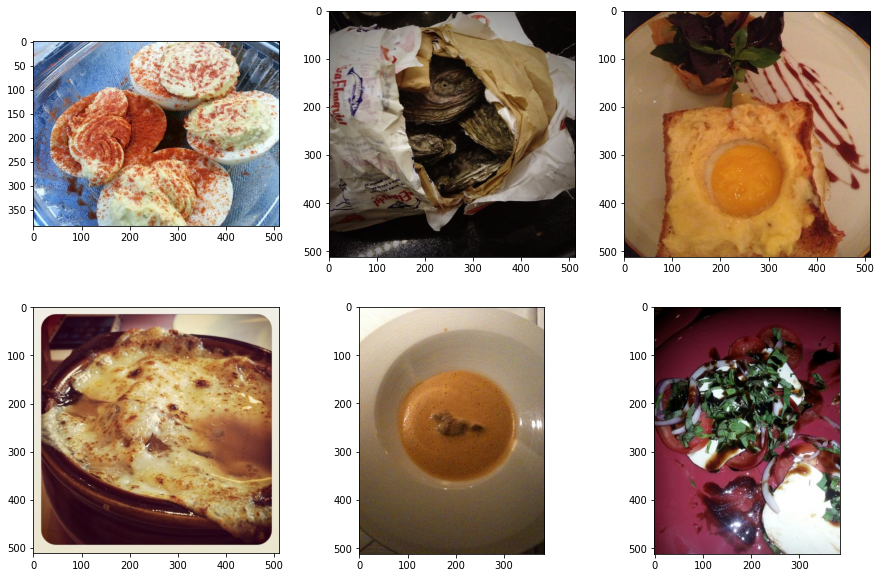

In [10]:
plt.figure(figsize=(15, 10))

for i in range(1, 7):
  food_name = random.choice(os.listdir(train_dir))
  img_name = random.choice(os.listdir(train_dir + food_name + '/'))
  img = mpimg.imread(train_dir + food_name + '/' + img_name)

  plt.subplot(2, 3, i)
  plt.imshow(img)

# Building a Temp Model to understand the Data better. We will modify the data and build better Models

Data Preprocessing

In [11]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                               label_mode='categorical',
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE,
                                                               shuffle=False)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)

Found 85850 files belonging to 101 classes.
Found 10100 files belonging to 101 classes.
Found 5050 files belonging to 101 classes.


Building an EfficinetNetB0 model

In [12]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False

# Make Conv-Blocks 1a, 2a, 2b Trainable 
for layer in base_model.layers[6:46]:
  layer.trainable = True

# Make Conv-Blocks 7a Trainable 
for layer in base_model.layers[-16:-4]:
  layer.trainable = True


inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_1D')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)


temp_model = tf.keras.Model(inputs, outputs)


temp_model.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['accuracy'])

temp_model_history = temp_model.fit(train_data,
                                    epochs=5,
                                    validation_data = test_data)

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/5
2683/2683 [==============================] - 406s 144ms/step - loss: 1.9740 - accuracy: 0.5045 - val_loss: 1.5525 - val_accuracy: 0.6024
Epoch 2/5
2683/2683 [==============================] - 378s 141ms/step - loss: 1.4495 - accuracy: 0.6186 - val_loss: 1.4852 - val_accuracy: 0.6259
Epoch 3/5
2683/2683 [==============================] - 378s 141ms/step - loss: 1.2998 - accuracy: 0.6533 - val_loss: 1.4944 - val_accuracy: 0.6224
Epoch 4/5
2683/2683 [==============================] - 386s 144ms/step - loss: 1.1998 - accuracy: 0.6750 - val_loss: 1.5350 - val_accuracy: 0.6212
Epoch 5/5
2683/2683 [==============================] - 384s 143ms/step - loss: 1.1312 - accuracy: 0.6895 - val_loss: 1.5437 - val_accuracy: 0.6271


In [55]:
temp_model.save('temp_model.h5')

# Analyzing the Model on Test Data

In [13]:
temp_model.evaluate(test_data)

158/158 [==============================] - 23s 148ms/step - loss: 1.5437 - accuracy: 0.6271


[1.5436813831329346, 0.6271287202835083]

In [14]:
pred_probs = temp_model.predict(test_data)
pred_probs[1]

array([3.24460561e-03, 1.60295367e-05, 2.06988654e-03, 2.94895057e-04,
       2.75648694e-04, 1.42289922e-04, 2.99495907e-04, 2.32084699e-06,
       1.45711878e-04, 7.04120830e-05, 1.23945009e-02, 9.04535045e-05,
       1.49903689e-02, 3.08783613e-02, 5.37274405e-03, 1.33157073e-05,
       3.38761165e-04, 1.80488192e-02, 3.35241821e-05, 1.34145710e-04,
       3.31117667e-06, 6.79497432e-04, 1.38036779e-03, 6.58213903e-05,
       6.09973154e-04, 1.33675057e-03, 8.14814062e-04, 6.73715374e-04,
       7.95183936e-04, 2.03404762e-03, 6.53127162e-03, 6.16982579e-04,
       1.05444116e-04, 1.62491016e-08, 3.07425787e-03, 1.20328029e-03,
       2.35049651e-04, 4.26551051e-05, 4.93568878e-05, 1.47027278e-03,
       1.37603763e-06, 5.85115282e-04, 3.97879339e-04, 2.83826580e-07,
       2.58265645e-05, 3.22272982e-08, 6.86643362e-01, 1.88465838e-05,
       1.56437800e-05, 1.14914663e-01, 4.41607961e-04, 9.42956660e-07,
       3.35724762e-04, 3.73892777e-04, 2.43032446e-07, 9.59019526e-04,
      

In [15]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:25]

array([  1,  46,   0,  41,   8,   2,   0,   0,  72,  56,   8, 100,  14,
        78,   2,   0,   0,  39,  98,   0,  84,  14, 100,   0,   0])

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

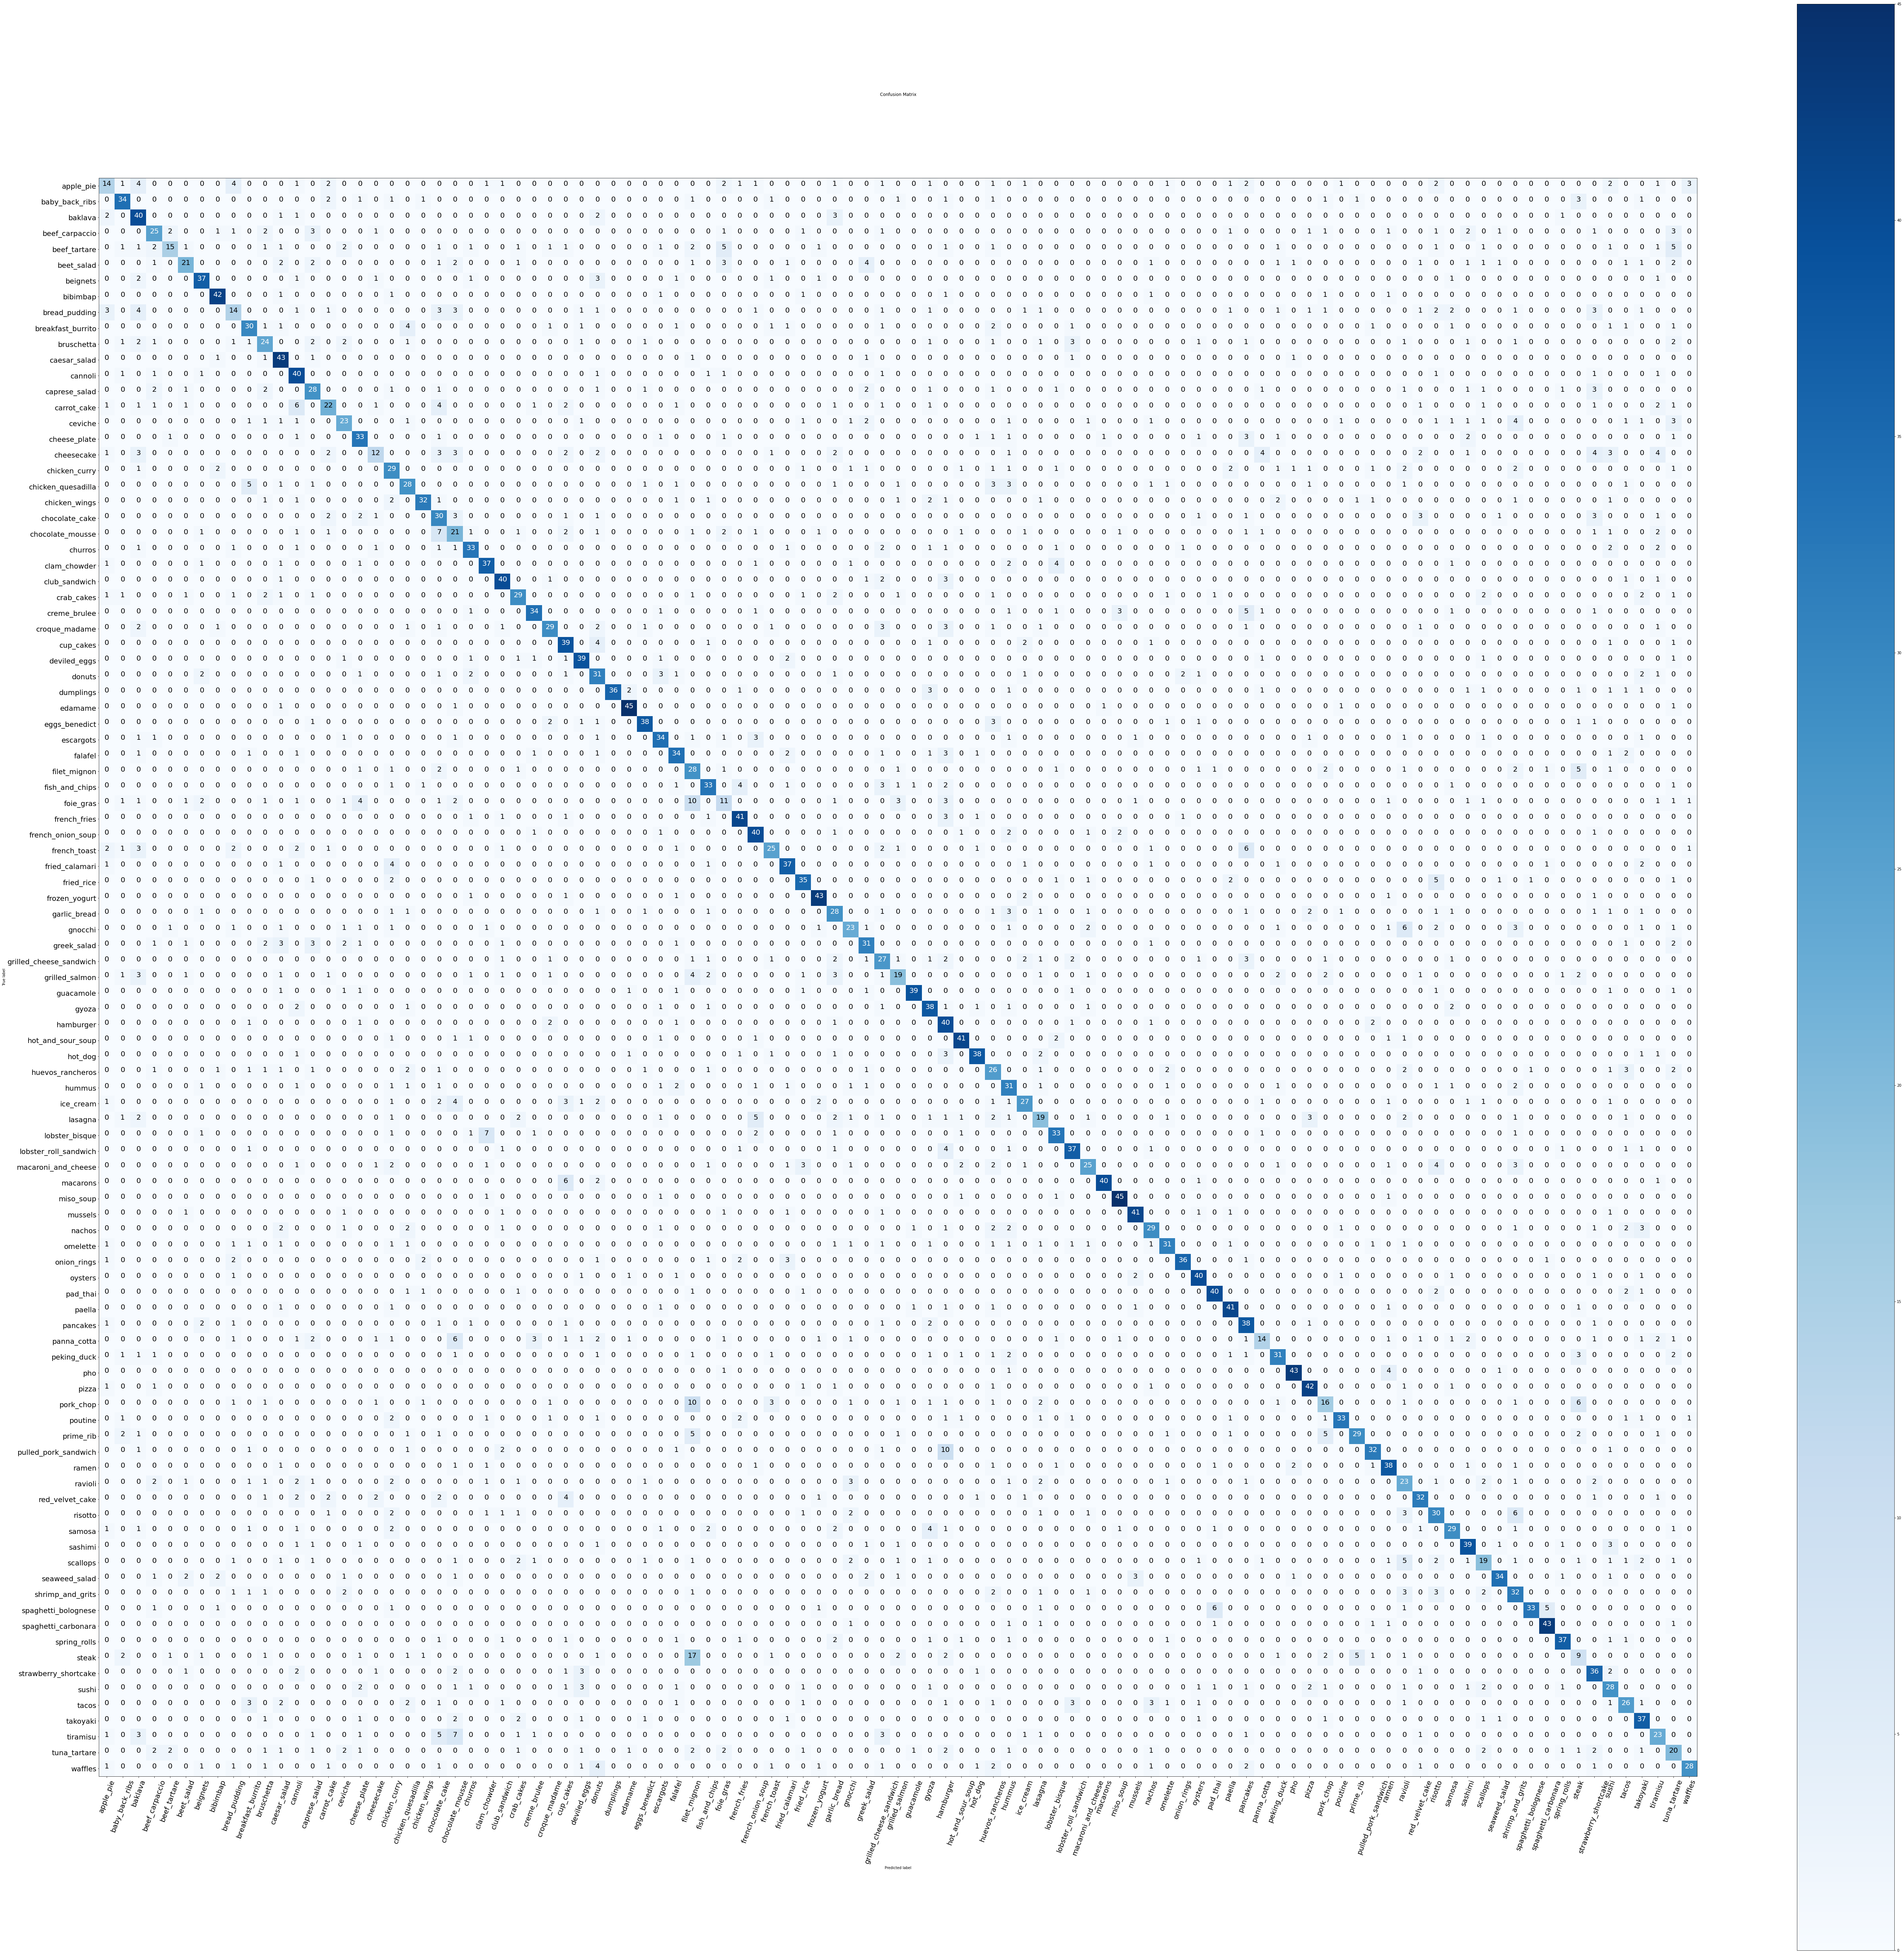

In [19]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels)
  
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  if savefig:
    fig.savefig("confusion_matrix.png")


make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=False)

From the Confusion Matrix, we can see that some categories give us huge false positives, Lets list out these categories to get more insight on the Data

In [53]:
x = []

cm = confusion_matrix(y_labels, pred_classes)

for i in range(0, len(test_data.class_names)):
  for j in range(0, len(test_data.class_names)):
    if (cm[i][j] >= 4) & (i != j):
      x.append([i,j])

names = []

for pair in x:
  temp = []
  for name in pair:
    temp.append(test_data.class_names[name])

  names.append(temp)

names

[['apple_pie', 'beef_carpaccio'],
 ['apple_pie', 'caesar_salad'],
 ['bibimbap', 'grilled_salmon'],
 ['bread_pudding', 'lobster_bisque'],
 ['caesar_salad', 'beef_carpaccio'],
 ['cake', 'crab_cakes'],
 ['chicken_quesadilla', 'cheese_plate'],
 ['chicken_quesadilla', 'croque_madame'],
 ['clam_chowder', 'sashimi'],
 ['crab_cakes', 'cake'],
 ['cup_cakes', 'croque_madame'],
 ['donuts', 'pancakes'],
 ['eggs_benedict', 'samosa'],
 ['falafel', 'foie_gras'],
 ['grilled_cheese_sandwich', 'guacamole'],
 ['grilled_salmon', 'churros'],
 ['grilled_salmon', 'gnocchi'],
 ['hot_and_sour_soup', 'samosa'],
 ['hot_dog', 'club_sandwich'],
 ['huevos_rancheros', 'tartare'],
 ['lasagna', 'tacos'],
 ['macaroni_and_cheese', 'gnocchi'],
 ['pad_thai', 'cup_cakes'],
 ['paella', 'hamburger'],
 ['pancakes', 'donuts'],
 ['peking_duck', 'mussels'],
 ['pho', 'tartare'],
 ['pizza', 'falafel'],
 ['sashimi', 'cup_cakes'],
 ['seaweed_salad', 'sushi'],
 ['spaghetti', 'gnocchi'],
 ['steak', 'gnocchi'],
 ['steak', 'spaghetti'],

From the above lists, we can see why the model misclassifies a few categories. We can see that they are very similar types of food and therefore the model struggles to classify them correctly

# Modifying Data for Better Performance

Some categories are too specific. Making them more general would improve Performance
<br>
<br>

Combine                   |To
--------------------------|--------------------------
Caprese Salad + Greek Salad + Beet Salad| Salad
Cheesecake + Carrot Cake + <br>Chocolate Cake + Red Velvet  Cake|Cake
Prime Ribs + Baby Back Ribs | Ribs
Spaghetti Bolognese + Spaghetti Carbonara | Spaghetti
Tuna Tartare + Beef Tartare|Tartare

<br>
<br>
Some Categories are very similar to others. Removing them would improve performance
<br>
<br>

Delete                    |Reason
--------------------------|--------------------------
Chocolate Mouse |Very Similar to cake, especially chocolate cake
Fillet Mignon |Very similar to Steak
Fried Calamari |They look exactly the same as Onion Rings but smaller
Gyoza |They are the same as Dumplings in a different Shape
Frozen Yoghurt |Very similar to Ice Cream
Tiramisu| Very similar to Chocolate Cake
Panna Cotta| Very Similar to a chocolate Cake



In [28]:
!rm -rf data

In [31]:
def combine_data(from_directory=[], to_directory=[]):
  
  if len(from_directory) != len(to_directory):
    raise Exception ('from_directory and to_directory are not of same length')

  for to_dir, from_dir in zip(to_directory, from_directory):
    to_dir_path = '/content/images/' + to_dir +'/'
    try:
      os.mkdir(to_dir_path)
    except:
      pass

    for category in from_dir:
      
      if category == to_dir:
        continue

      from_dir_path = '/content/images/' + category +'/'

      filenames = os.listdir(from_dir_path)

      for filename in filenames:
        shutil.move(from_dir_path + filename, to_dir_path + filename)
      
      os.rmdir(from_dir_path)


def delete_data(delete_direcroty_list=[]):
  
  for directory in delete_direcroty_list:
    shutil.rmtree('/content/images/' + directory +'/')


from_directory_list = [['caprese_salad', 'greek_salad', 'beet_salad'],
                       ['cheesecake', 'carrot_cake', 'chocolate_cake', 'red_velvet_cake'],
                       ['prime_rib', 'baby_back_ribs'],
                       ['spaghetti_bolognese', 'spaghetti_carbonara'],
                       ['tuna_tartare', 'beef_tartare']
]

to_directory_list = ['salad', 'cake', 'ribs', 'spaghetti', 'tartare']

delete_directory_list = ['chocolate_mousse', 'filet_mignon', 'fried_calamari', 
                         'gyoza', 'frozen_yogurt', 'tiramisu', 'panna_cotta']

combine_data(from_directory_list, to_directory_list)
delete_data(delete_directory_list)

In [32]:
split_data(raw_data_dir)

In [33]:
!rm -rf images
!rm food41.zip

# Building 3 Transfer Learning Models on the Modified Data


* Resnet50V2
* MobileNet
* EfficientNetB0

Preprocessing the Data

In [34]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                               label_mode='categorical',
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE,
                                                               shuffle=False)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)

Found 79900 files belonging to 86 classes.
Found 9400 files belonging to 86 classes.
Found 4700 files belonging to 86 classes.


Creating an Augmentation Layer for Better Performance. EfficientNet does not require Rescaling but MobileNet and ResNet Requires Rescaling

In [40]:
data_aug_layer = tf.keras.Sequential([
                             tf.keras.layers.RandomFlip('horizontal'),
                             tf.keras.layers.RandomRotation(0.2),
                             tf.keras.layers.RandomTranslation(0.1, 0.1),
                             tf.keras.layers.RandomContrast(0.1),
], name='data_augmentation_layer_no_rescaling')


data_aug_layer_with_rescaling = tf.keras.Sequential([
                                            tf.keras.layers.RandomFlip('horizontal'),
                                            tf.keras.layers.RandomRotation(0.2),
                                            tf.keras.layers.RandomTranslation(0.1, 0.1),
                                            tf.keras.layers.RandomContrast(0.1),
                                            tf.keras.layers.Rescaling(1/255.)
], name='data_augmentation_layer_with_rescaling')

Checking the Layer of the 3 Models

In [47]:
# base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
# base_model = tf.keras.applications.MobileNet(include_top=True, weights='imagenet')
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')

94683136/94668760 [==============================] - 2s 0us/step


In [49]:
# for layer in base_model.layers:
#   print(layer.name)

Building the EfficientNetB0 Model

In [50]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False

# Make Conv-Blocks 1a, 2a, 2b Trainable 
for layer in base_model.layers[6:46]:
  layer.trainable = True

# Make Conv-Blocks 7a Trainable 
for layer in base_model.layers[-16:-4]:
  layer.trainable = True

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_aug_layer(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_1D')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)


efficient_net_model = tf.keras.Model(inputs, outputs)


efficient_net_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

efficient_net_model_history = efficient_net_model.fit(train_data,
                          epochs=20,
                          validation_data = val_data)

Epoch 1/20
2497/2497 [==============================] - 432s 169ms/step - loss: 2.1940 - accuracy: 0.4532 - val_loss: 1.6820 - val_accuracy: 0.5700
Epoch 2/20
2497/2497 [==============================] - 399s 160ms/step - loss: 1.7457 - accuracy: 0.5481 - val_loss: 1.5773 - val_accuracy: 0.5959
Epoch 3/20
2497/2497 [==============================] - 398s 159ms/step - loss: 1.6316 - accuracy: 0.5768 - val_loss: 1.5494 - val_accuracy: 0.6055
Epoch 4/20
2497/2497 [==============================] - 397s 159ms/step - loss: 1.5695 - accuracy: 0.5894 - val_loss: 1.5258 - val_accuracy: 0.6143
Epoch 5/20
2497/2497 [==============================] - 397s 159ms/step - loss: 1.5276 - accuracy: 0.5956 - val_loss: 1.5192 - val_accuracy: 0.6185
Epoch 6/20
2497/2497 [==============================] - 397s 159ms/step - loss: 1.4876 - accuracy: 0.6089 - val_loss: 1.5179 - val_accuracy: 0.6174
Epoch 7/20
 246/2497 [=>............................] - ETA: 5:27 - loss: 1.4819 - accuracy: 0.6118

KeyboardInterrupt: ignored

Building the MobileNet Model

In [ ]:
base_model = tf.keras.applications.MobileNet(include_top=True, weights='imagenet')
base_model.trainable = False

# Make Conv-Blocks 1, 2, 3, 4 Trainable 
for layer in base_model.layers[1:29]:
  layer.trainable = True

# Make Conv-Blocks 12, 13 Trainable 
for layer in base_model.layers[-18:-3]:
  layer.trainable = True

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_aug_layer_with_rescaling(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)


mobile_net_model = tf.keras.Model(inputs, outputs)


mobile_net_model.compile(loss='categorical_crossentropy',
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=['accuracy'])

mobile_net_model_history = mobile_net_model.fit(train_data,
                                                epochs=20,
                                                validation_data=val_data)

Building the ResNet50V2 Model

In [ ]:
base_model = tf.keras.applications.ResNet50V2(include_top=True, weights='imagenet')
base_model.trainable = False

# Make Conv-Blocks 1 Trainable
for layer in base_model.layers[1:27]:
  layer.trainable = True

# Make Conv-Blocks 5 Trainable
for layer in base_model.layers[-36:-3]:
  layer.trainable = True


inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_aug_layer_with_rescaling(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)


resnet50_model = tf.keras.Model(inputs, outputs)


resnet50_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

resnet50_model_history = resnet50_model.fit(train_data,
                          epochs=20,
                          validation_data = val_data)

Evauating the Results of the 3 Models

In [ ]:
num = 0

for mod_, name in zip([efficient_net_model_history, resnet50_model_history, mobile_net_model_history], ['EfficientNetB0', 'Resnet50V2', 'MobileNet201'])

  num = num + 1

  loss = mod_.history['loss']
  val_loss = mod_.history['val_loss']

  accuracy = mod_.history['accuracy']
  val_accuracy = mod_.history['val_accuracy']

  epochs = range(len(mod_.history['loss']))

  #Plot loss
  plt.subplot(2, 3, i)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title(name + 'Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.subplot(2, 3, i+3)
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title(name + 'Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [ ]:
efficient_net_model_results = efficient_net_model.evaluate(test_data)

In [ ]:
mobile_net_model_results = mobile_net_model.evaluate(test_data)

In [ ]:
resnet50_model_results = resnet50_model.evaluate(test_data)

Saving the 3 Models

In [ ]:
resnet50_model.save('Resnet50V2_model')
mobile_net_model.save('MobileNet201_model')
efficient_net_model.save('EfficientNetB0_model')

In [ ]:
class_names = test_data.class_names

# Preparing Data For Prediction

In [ ]:
def load_and_prep_image(filename, img_shape=256, scale=True):

  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.grayscale_to_rgb(img)
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(9):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + '/' + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale=False)
  pred_prob = efficient_net_model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max()*100:.2f}", c=title_color)
  plt.axis(False);